<a href="https://colab.research.google.com/github/JustinWongStanford/CS330P/blob/master/FCMlatent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TOP

In [1]:
! git clone https://github.com/authors-1901-10912/A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms.git

Cloning into 'A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms'...
remote: Enumerating objects: 51, done.
remote: Total 51 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (51/51), done.


In [2]:
! git pull

fatal: not a git repository (or any of the parent directories): .git


In [3]:
!ln -s A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms gitcode

In [4]:
!ls

A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms
gitcode
sample_data


In [5]:
!pip install -r gitcode/requirements.txt

     |████████████████████████████████| 591.8MB 29kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.0.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [6]:
% cd gitcode

/content/A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms


In [7]:
!ln -s ../A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms/notebooks/bivariate-continuous-multimodal/ bcm

In [8]:

! ls 

# ! pip install .

bcm	causal_meta  notebooks	requirements.txt
causal	__init__.py  README.md	run.py


In [9]:
import sys
# sys.path.append('../..')

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from scipy import interpolate

import random
import tqdm
from copy import deepcopy
from argparse import Namespace
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
# from causal_meta.modules import networks as nets
from causal_meta.utils.data_utils import RandomSplineSCM

import causal_meta.utils.train_utils as tu
# from bcm.encoder import Rotor
from causal_meta.modules.mdn import MDN, GMM, mdn_nll
from causal_meta.modules.gmm import GaussianMixture

In [12]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

from causal_meta.modules.mdn import mdn_nll
from causal_meta.utils.data_utils import RandomSplineSCM
from causal_meta.utils.train_utils import train_nll, make_alpha, train_alpha
from bcm.models import mdn, gmm, auc_transfer_metric
from argparse import Namespace

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCMMDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians = 1):
        super(FCMMDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(2, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)

    def forward(self, x, z):
        y = torch.cat([x, z], dim=-1)
        z_h = self.z_h(y)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma


class FCM_muSigma(nn.Module):
    def __init__(self, n_hidden, n_gaussians = 1):
        super(FCM_muSigma, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)

    def forward(self, x):
        z_h = self.z_h(x)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return mu, sigma
        

In [14]:
SEED = 91023
torch.manual_seed(SEED)
np.random.seed(SEED)

# Boilerplate

In [15]:
def normal(mean, std, N): 
    return torch.normal(torch.ones(N).mul_(mean), torch.ones(N).mul_(std)).view(-1, 1)

In [28]:
# opt = Namespace()
# # Model
# opt.CAPACITY = 32
# opt.NUM_COMPONENTS = 10
# opt.GMM_NUM_COMPONENTS = 10
# # Training
# opt.LR = 0.001
# opt.NUM_ITER = 3000
# opt.CUDA = False
# opt.REC_FREQ = 10
# # Meta
# opt.ALPHA_LR = 0.1
# opt.ALPHA_NUM_ITER = 500
# opt.FINETUNE_LR = 0.001
# opt.FINETUNE_NUM_ITER = 10
# opt.PARAM_DISTRY = lambda mean: normal(mean, 2, opt.NUM_SAMPLES)
# opt.PARAM_SAMPLER = lambda: np.random.uniform(-4, 4)
# # Sampling 
# opt.NUM_SAMPLES = 1000
# opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
# opt.TRANS_DISTRY = lambda: normal(random.randint(-4, 4), 2, opt.NUM_SAMPLES)

opt = Namespace()

# Model
opt.CAPACITY = 32
opt.NUM_COMPONENTS = 10
# opt.GMM_NUM_COMPONENTS = 10
opt.GMM_NUM_COMPONENTS = 10
opt.Z_COMPONENTS = 1
opt.W_COMPONENTS = 1


# Training
opt.LR = 0.01
opt.NUM_ITER = 500
opt.NUM_META_ITER = 1000
opt.ALPHA_LR = 0.01
opt.ALPHA_NUM_ITER = 1000
opt.CUDA = True
opt.REC_FREQ = 10
opt.ALPHA_INIT = 0.
opt.USE_BASELINE = True
opt.MONTE_CARLO_STEPS = 300

# Fine tuning
opt.FINETUNE_NUM_ITER = 5
opt.FINETUNE_LR = 0.001
opt.EM_ITERS = 300

# Sampling 
opt.NUM_SAMPLES = 1000
opt.TRAIN_DISTRY = lambda z: normal(0, 2, opt.NUM_SAMPLES) + z
opt.TRANS_DISTRY = lambda z: normal(np.random.uniform(-4, 4), 
                                  2, opt.NUM_SAMPLES) + z
opt.DISTR_FOR_Z = lambda: normal(0, 4, opt.NUM_SAMPLES)
opt.DISTR_FOR_W = lambda z: normal(2, 2, opt.NUM_SAMPLES) + z

opt.PARAM_DISTRY = lambda mean, z: normal(mean, 2, opt.NUM_SAMPLES) + z
opt.PARAM_SAMPLER = lambda: np.random.uniform(-4, 4)
opt.ALPHA_NUM_ITER = 500

# Encoder
opt.DECODER_DEFAULT = -float(0.5 * np.pi/2)

In [29]:
import torch
import torch.nn as nn
import numpy as np
import scipy
from scipy import interpolate
try:
    import matplotlib.pyplot as plt
except Exception: 
    plt = None

class RandomSplineSCM(nn.Module): 
    def __init__(self, input_noise=False, output_noise=True, 
                 span=6, num_anchors=10, order=3, range_scale=1.): 
        super(RandomSplineSCM, self).__init__()
        self._span = span
        self._num_anchors = num_anchors
        self._range_scale = range_scale
        self._x = np.linspace(-span, span, num_anchors)
        self._y = np.random.uniform(-range_scale * span, range_scale * span, 
                                    size=(num_anchors,))
        self._spline_spec = interpolate.splrep(self._x, self._y, k=order)
        self.input_noise = input_noise
        self.output_noise = output_noise
    
    def forward(self, X, Z=None):
        #if Z is None: 
        to_add = Z + self.sample(X.shape[0])
        if self.input_noise: 
            X = X + Z
        X_np = X.detach().cpu().numpy().squeeze()
        _Y_np = interpolate.splev(X_np, self._spline_spec)
        _Y = torch.from_numpy(_Y_np).view(-1, 1).float().to(X.device)
        if self.output_noise:
            Y = _Y + to_add
        else: 
            Y = _Y
        return Y
        
    def sample(self, N): 
        return torch.normal(torch.zeros(N), torch.ones(N)).view(-1, 1)
    
    def plot(self, X, title="Samples from the SCM", label=None, show=True): 
        Y = self(X)
        if show:
            plt.figure()
            plt.title(title)
        plt.scatter(X.squeeze().numpy(), Y.squeeze().numpy(), marker='+', label=label)
        if show:
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.show()


def mdn_nll(pi_mu_sigma, y, mu_sigma_z, mu_sigma_w, z, w, reduce=True):
    pi, mu, sigma = pi_mu_sigma
    mu_w, sigma_w = mu_sigma_w
    mu_z, sigma_z = mu_sigma_z
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    mz = torch.distributions.Normal(loc=0, scale=1)
    mzGw = torch.distributions.Normal(loc=mu_z, scale=sigma_z)
    mw = torch.distributions.Normal(loc=mu_w, scale=sigma_w)

    log_prob_y = m.log_prob(y)
    log_prob_w = mw.log_prob(w)
    log_prob_z = mz.log_prob(z)
    log_prob_zGw = mzGw.log_prob(z) 
    log_prob_pi_y = log_prob_y + torch.log(pi)
    loss = - (log_prob_w.reshape(-1) + log_prob_z.reshape(-1) - log_prob_zGw.reshape(-1) + torch.logsumexp(log_prob_pi_y, dim=1))
    if reduce:
        return torch.mean(loss)
    else:
        return loss


In [30]:
scm = RandomSplineSCM(False, True, 8, 10, 3, range_scale=1.)

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from causal_meta.utils.torch_utils import logsumexp
from tqdm import tnrange, tqdm_notebook, notebook
from argparse import Namespace
from copy import deepcopy


def inner_train_fn(inp, tar, W, Z_inner, model, model_wGz, out_zGw, loss_fn):
  out = model(inp, Z_inner)
  out_wGz = model_wGz(Z_inner)
  loss = loss_fn(out, tar, out_zGw, out_wGz, Z_inner, W, reduce = False)
  return loss.reshape(-1, 1)


def train_nll(opt, model, model_zGw, model_wGz, scm, train_distr_fn, Z_distr_fn, W_distr_fn, polarity='X2Y', loss_fn=nn.MSELoss(),
              decoder=None, encoder=None):
    optim = torch.optim.Adam(model.parameters(), lr=opt.LR)
    optim_wGz = torch.optim.Adam(model_wGz.parameters(), lr=opt.LR)
    optim_zGw = torch.optim.Adam(model_zGw.parameters(), lr=opt.LR)
    if opt.CUDA:
        model = model.cuda()
        model_zGw = model_zGw.cuda()
        model_wGz = model_wGz.cuda()
        if encoder is not None: 
            encoder = encoder.cuda()
        if decoder is not None: 
            decoder = decoder.cuda()
    frames = []
    for iter_num in tnrange(opt.NUM_ITER, leave=False):
        # Generate samples from the training distry
        Z = Z_distr_fn()
        X = train_distr_fn(Z)
        W = W_distr_fn(Z)
        with torch.no_grad():
            Y = scm(X, Z)
        if opt.CUDA:
            X, Y = X.cuda(), Y.cuda()
        with torch.no_grad():
            if decoder is not None:
                # X and Y are sampled from the underlying distribution.
                # We apply a secret random transformation to the true latent
                # variables to obtain the raw input
                X, Y = decoder(X, Y)
            if encoder is not None:
                # Apply the encoder, meant to "undo" the decoder up to swapping X and Y.
                X, Y = encoder(X, Y)
        # Now, train as usual
        if polarity == 'X2Y':
            inp, tar = X, Y
        elif polarity == 'Y2X':
            inp, tar = Y, X
        else:
            raise ValueError
        if opt.CUDA:
            inp, tar = inp.cuda(), tar.cuda()
            Z = Z.cuda()
            W = W.cuda()
        # Train
        out_zGw = model_zGw(W)
        mu_z, sz = out_zGw
        z_normal = torch.distributions.Normal(0, 1)
        # if opt.CUDA:
        #   z_normal = z_normal.cuda()
        
        #monte_carlo_z = []
        #print(mu_z.shape, sz.shape)
        #print(z_normal.sample((opt.MONTE_CARLO_STEPS,1)).shape)
        #print(z_normal.sample((opt.MONTE_CARLO_STEPS,1))*sz.shape)
        samples = z_normal.sample((opt.MONTE_CARLO_STEPS, 1))
        inp2 = sz.reshape(1, -1)
        inp3 = torch.cat([mu_z.reshape(1, -1) for i in range(opt.MONTE_CARLO_STEPS)], 0)
        if opt.CUDA:
          samples = samples.cuda()
          inp2 = inp2.cuda()
          inp3 = inp3.cuda()

        Z_inner = torch.matmul(samples, inp2) +  inp3
        Z_inner = Z_inner.reshape(-1, 1)
        tar = torch.cat([tar for i in range(opt.MONTE_CARLO_STEPS)], 0)
        inp = torch.cat([inp for i in range(opt.MONTE_CARLO_STEPS)], 0)
        W = torch.cat([W for i in range(opt.MONTE_CARLO_STEPS)], 0)

        mu_z_pass = torch.cat([mu_z for i in range(opt.MONTE_CARLO_STEPS)], 0)
        s_z_pass = torch.cat([sz for i in range(opt.MONTE_CARLO_STEPS)], 0)

        lo = inner_train_fn(inp, tar, W, Z_inner, model, model_wGz, (mu_z_pass, s_z_pass), loss_fn)
        loss = torch.mean(lo)

        optim.zero_grad()
        optim_wGz.zero_grad()
        optim_zGw.zero_grad()
        loss.backward()
        optim.step()
        optim_wGz.step()
        optim_zGw.step()
        # Append info
        if iter_num % opt.REC_FREQ or iter_num == (opt.NUM_ITER - 1):
            info = Namespace(loss=loss.item(),
                             iter_num=iter_num)
            frames.append(info)
    return frames

def marginal_nll(opt, inp, nll): 
    model_g = gmm(opt)
    if opt.CUDA: 
        model_g = model_g.cuda()
    model_g.fit(inp)
    with torch.no_grad():
        loss_marginal = nll(model_g(inp), inp)
    return loss_marginal

def transfer_tune(opt, model, model_wGz, model_zGw, inp, tar, W, nll): 
    model = deepcopy(model)
    model_wGz = deepcopy(model_wGz)
    model_zGw = deepcopy(model_zGw)
    optim_model = torch.optim.Adam(model.parameters(), 
                                   opt.FINETUNE_LR)
    #loss_marginal = marginal_nll(opt, inp[0], nll).item()
    joint_losses = []
    if opt.CUDA:
      W = W.cuda()
    for iter_num in range(opt.FINETUNE_NUM_ITER): 
        # Train conditional
        out_zGw = model_zGw(W)
        mu_z, sz = out_zGw
        z_normal = torch.distributions.Normal(0, 1) 
        
        samples = z_normal.sample((opt.MONTE_CARLO_STEPS, 1))
        inp2 = sz.reshape(1, -1)
        inp3 = torch.cat([mu_z.reshape(1, -1) for i in range(opt.MONTE_CARLO_STEPS)], 0)
        if opt.CUDA:
          samples = samples.cuda()
          inp2 = inp2.cuda()
          inp3 = inp3.cuda()

        Z_inner = torch.matmul(samples, inp2) +  inp3
        # Z_inner = torch.matmul(z_normal.sample((opt.MONTE_CARLO_STEPS, 1)), sz.reshape(1, -1)) + torch.cat([mu_z.reshape(1, -1) for i in range(opt.MONTE_CARLO_STEPS)], 0)
        Z_inner = Z_inner.reshape(-1, 1)
        tar_use = torch.cat([tar for i in range(opt.MONTE_CARLO_STEPS)], 0)
        inp_use = torch.cat([inp for i in range(opt.MONTE_CARLO_STEPS)], 0)
        W_use = torch.cat([W for i in range(opt.MONTE_CARLO_STEPS)], 0)

        mu_z_pass = torch.cat([mu_z for i in range(opt.MONTE_CARLO_STEPS)], 0)
        s_z_pass = torch.cat([sz for i in range(opt.MONTE_CARLO_STEPS)], 0)
        
        out = model(inp_use, Z_inner)
        out_wGz = model_wGz(Z_inner)
        lo = nll(out, tar_use, (mu_z_pass, s_z_pass), out_wGz, Z_inner, W_use, reduce = False)

        loss_conditional = torch.mean(lo)
        #prd = model(inp[0], inp[1])
        #loss_conditional = nll(prd, tar)
        optim_model.zero_grad()
        loss_conditional.backward()
        optim_model.step()
        joint_losses.append(loss_conditional.item()) # + loss_marginal)
    # Return losses
    return joint_losses

def auc_transfer_metric(opt, model, model_wGz, model_zGw, inp, tar, W, nll):
    # Tune
    losses = transfer_tune(opt, model, model_wGz, model_zGw, inp, tar, W, nll)
    # Compute the integral of the loss curve
    return sum(losses)

def train_alpha(opt, model_x2y, model_y2x, model_x2y_wGz, model_x2y_zGw, 
                model_y2x_wGz, model_y2x_zGw, alpha, gt_scm, 
                distr, Z_distr_fn, W_distr_fn, sweep_distr, nll, transfer_metric, mixmode='logmix'):
    # Everyone to CUDA
    if opt.CUDA: 
        model_x2y.cuda()
        model_y2x.cuda()
    alpha_optim = torch.optim.Adam([alpha], lr=opt.ALPHA_LR)
    frames = []
    iterations = tnrange(opt.ALPHA_NUM_ITER, leave=False)
    for iter_num in iterations:
        # Sample parameter for the transfer distribution
        sweep_param = sweep_distr()
        # Sample X from transfer
        #zx = normal(0, 1, 1000)
        #zy = normal(0, 1, 1000)
        Z = Z_distr_fn()
        X_gt = distr(sweep_param, Z)
        W = W_distr_fn(Z)
        Y_gt = gt_scm(X_gt, Z)
        with torch.no_grad():
            if opt.CUDA:
                X_gt, Y_gt = X_gt.cuda(), Y_gt.cuda()
        # Evaluate performance
        metric_x2y = transfer_metric(opt, model_x2y, model_x2y_wGz, model_x2y_zGw, X_gt, Y_gt, W, nll)
        metric_y2x = transfer_metric(opt, model_y2x, model_y2x_wGz, model_y2x_zGw, Y_gt, X_gt, W, nll)
        # Estimate gradient
        if mixmode == 'logmix':
            loss_alpha = torch.sigmoid(alpha) * metric_x2y + (1 - torch.sigmoid(alpha)) * metric_y2x
        else:
            log_alpha, log_1_m_alpha = F.logsigmoid(alpha), F.logsigmoid(-alpha)
            as_lse = logsumexp(log_alpha + metric_x2y, log_1_m_alpha + metric_y2x)
            if mixmode == 'logsigp': 
                loss_alpha = as_lse
            elif mixmode == 'sigp':
                loss_alpha = as_lse.exp()
        # Optimize
        alpha_optim.zero_grad()
        loss_alpha.backward()
        alpha_optim.step()
        # Append info
        with torch.no_grad():
            frames.append(Namespace(iter_num=iter_num,
                                    alpha=alpha.item(), 
                                    sig_alpha=torch.sigmoid(alpha).item(), 
                                    metric_x2y=metric_x2y, 
                                    metric_y2x=metric_y2x, 
                                    loss_alpha=loss_alpha.item()))
        iterations.set_postfix(alpha='{0:.4f}'.format(torch.sigmoid(alpha).item()))
    return frames

In [32]:
# def mdn(opt): 
#     return MDN(opt.CAPACITY, opt.NUM_COMPONENTS)

def mdn(opt): 
    return FCMMDN(opt.CAPACITY, opt.NUM_COMPONENTS)
def mdn_mu_sigma_z(opt): 
    return FCM_muSigma(opt.CAPACITY, opt.Z_COMPONENTS)
def mdn_mu_sigma_w(opt): 
    return FCM_muSigma(opt.CAPACITY, opt.W_COMPONENTS)
def gmm(opt): 
    return GaussianMixture(opt.GMM_NUM_COMPONENTS)

In [33]:
!pip install line_profiler
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [55]:
model_x2y = mdn(opt)
model_x2y_wGz = mdn_mu_sigma_w(opt)
model_x2y_zGw = mdn_mu_sigma_z(opt)
# myfunc = lambda: train_nll(opt, model_x2y, model_x2y_zGw, model_x2y_wGz, scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='X2Y',loss_fn=mdn_nll, decoder=None, encoder=None)
%lprun -f train_nll train_nll(opt, model_x2y, model_x2y_zGw, model_x2y_wGz, scm, opt.TRAIN_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='X2Y',loss_fn=mdn_nll, decoder=None, encoder=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [62]:
model_x2y = mdn(opt)
model_x2y_wGz = mdn_mu_sigma_w(opt)
model_x2y_zGw = mdn_mu_sigma_z(opt)
frames_x2y = train_nll(opt, model_x2y, model_x2y_zGw, model_x2y_wGz, scm, opt.TRAIN_DISTRY, 
                       opt.DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='X2Y',
                        loss_fn=mdn_nll, decoder=None, encoder=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [63]:
model_y2x = mdn(opt)
model_y2x_wGz = mdn_mu_sigma_w(opt)
model_y2x_zGw = mdn_mu_sigma_z(opt)
frames_y2x = train_nll(opt, model_y2x, model_y2x_zGw, model_y2x_wGz, scm, opt.TRAIN_DISTRY, 
                       opt.DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='Y2X',
                        loss_fn=mdn_nll, decoder=None, encoder=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [64]:
alpha = make_alpha(opt)
alpha_frames = train_alpha(opt, model_x2y, model_y2x, model_x2y_zGw, model_x2y_wGz, 
                           model_y2x_zGw, model_y2x_wGz, alpha, scm, 
                           opt.PARAM_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                           opt.PARAM_SAMPLER, mdn_nll,
                           auc_transfer_metric, mixmode='logsigp')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


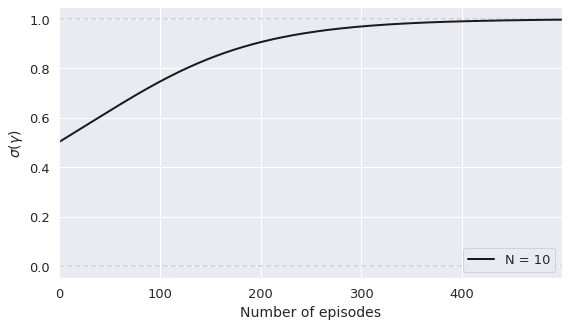

In [65]:
alphas = np.asarray([frame.sig_alpha for frame in alpha_frames])

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
ax.plot(alphas, lw=2, color='k', label='N = {0}'.format(10))

ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})

plt.show()

In [ ]:
alphas

array([0.5025    , 0.50500017, 0.50750059, 0.51000142, 0.51250261,
       0.5150044 , 0.51750672, 0.52000964, 0.52251333, 0.52501774,
       0.52752292, 0.530029  , 0.53253591, 0.53504378, 0.53755254,
       0.54006225, 0.54257292, 0.54508454, 0.54759711, 0.55011052,
       0.55262494, 0.5551402 , 0.55765629, 0.56017321, 0.56269085,
       0.56520915, 0.56772816, 0.57024765, 0.57276762, 0.575288  ,
       0.57780874, 0.58032966, 0.58285064, 0.58537167, 0.58789259,
       0.59041327, 0.59293365, 0.59545356, 0.59797287, 0.60049146,
       0.60300916, 0.60552591, 0.60804147, 0.61055577, 0.61306864,
       0.6155799 , 0.61808944, 0.62059712, 0.62310272, 0.62560606,
       0.62810713, 0.63060558, 0.63310134, 0.63559431, 0.63808417,
       0.64057094, 0.64305425, 0.64553404, 0.64801025, 0.65048248,
       0.6529507 , 0.65541476, 0.65787441, 0.66032958, 0.66277999,
       0.66522557, 0.66766602, 0.6701014 , 0.67253131, 0.67495573,
       0.67737442, 0.67978728, 0.68219405, 0.68459463, 0.68698

In [ ]:
torch.exp(torch.distributions.Normal(0, 1).log_prob(torch.tensor(0)))

tensor(0.3989)

In [ ]:
torch.distributions.Normal(3, 10).sample()

In [ ]:
W = opt.DISTR_FOR_Z()
torch.cat([W for i in range(3)], 0).shape

torch.Size([3000, 1])

In [ ]:
a = torch.distributions.Normal(0, 1).sample((10, 1)) 
g = torch.Tensor([1,2, 3, 4, 5]).reshape(-1, 1) #.reshape(-1, 1)
b = torch.cat([a for i in range(5)], 1)
b.reshape(-1, 1)[0]

l = torch.matmul(a, g.reshape(1, -1))
h = torch.Tensor([1,2, 3, 4, 5]).reshape(-1, 1)
l = l + torch.cat([h.reshape(1, -1) for i in range(10)], 0)
l

tensor([[ 1.2846,  2.5692,  3.8538,  5.1383,  6.4229],
        [ 1.3914,  2.7829,  4.1743,  5.5658,  6.9572],
        [ 1.3097,  2.6195,  3.9292,  5.2390,  6.5487],
        [ 2.5245,  5.0491,  7.5736, 10.0982, 12.6227],
        [ 0.3886,  0.7772,  1.1659,  1.5545,  1.9431],
        [ 1.7679,  3.5358,  5.3037,  7.0717,  8.8396],
        [-0.0694, -0.1389, -0.2083, -0.2778, -0.3472],
        [-0.6110, -1.2221, -1.8331, -2.4442, -3.0552],
        [-0.0453, -0.0905, -0.1358, -0.1811, -0.2263],
        [ 1.8414,  3.6827,  5.5241,  7.3655,  9.2068]])

In [ ]:
l.reshape(-1, 1)

tensor([[ 1.2846],
        [ 2.5692],
        [ 3.8538],
        [ 5.1383],
        [ 6.4229],
        [ 1.3914],
        [ 2.7829],
        [ 4.1743],
        [ 5.5658],
        [ 6.9572],
        [ 1.3097],
        [ 2.6195],
        [ 3.9292],
        [ 5.2390],
        [ 6.5487],
        [ 2.5245],
        [ 5.0491],
        [ 7.5736],
        [10.0982],
        [12.6227],
        [ 0.3886],
        [ 0.7772],
        [ 1.1659],
        [ 1.5545],
        [ 1.9431],
        [ 1.7679],
        [ 3.5358],
        [ 5.3037],
        [ 7.0717],
        [ 8.8396],
        [-0.0694],
        [-0.1389],
        [-0.2083],
        [-0.2778],
        [-0.3472],
        [-0.6110],
        [-1.2221],
        [-1.8331],
        [-2.4442],
        [-3.0552],
        [-0.0453],
        [-0.0905],
        [-0.1358],
        [-0.1811],
        [-0.2263],
        [ 1.8414],
        [ 3.6827],
        [ 5.5241],
        [ 7.3655],
        [ 9.2068]])

In [ ]:
h = torch.Tensor([1,2, 3, 4, 5]).reshape(-1, 1)
torch.cat([h.reshape(1, -1) for i in range(10)], 0)

tensor([[1., 2., 3., 4., 5.],
        [1., 2., 3., 4., 5.],
        [1., 2., 3., 4., 5.],
        [1., 2., 3., 4., 5.],
        [1., 2., 3., 4., 5.],
        [1., 2., 3., 4., 5.],
        [1., 2., 3., 4., 5.],
        [1., 2., 3., 4., 5.],
        [1., 2., 3., 4., 5.],
        [1., 2., 3., 4., 5.]])

In [ ]:
h = torch.Tensor([1,2, 3, 4, 5]).reshape(-1, 1)
torch.cat([h for i in range(10)], 0)

tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]])